## License Plate Detection and Recognition
**This notebook performs license plate detection (YOLOv8) and OCR using a CRNN model.
The goal is to extract the first 7 digits from each license plate and submit predictions in one-hot encoded format.**

checking the dim on the image

# checking the data which is given.

Sample entries:
     img_id  ymin  xmin  ymax  xmax
0    1.jpg   276    94   326   169
1   10.jpg   311   395   344   444
2  100.jpg   406   263   450   434
3  101.jpg   283   363   315   494
4  102.jpg   139    42   280   222


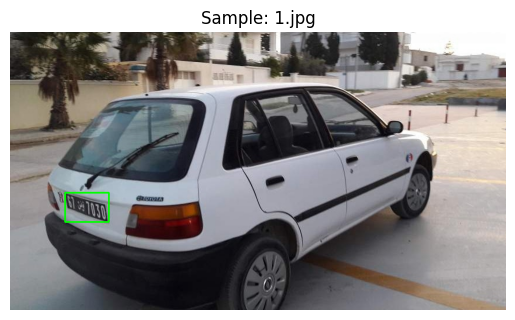

In [4]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt

detection_csv_path = '/content/drive/MyDrive/Colab Notebooks/NUMBER-PLATE/Licplatesdetection_train.csv'

# Load CSV
df_det = pd.read_csv(detection_csv_path)
print("Sample entries:\n", df_det.head())
img_folder = '/content/drive/MyDrive/Colab Notebooks/NUMBER-PLATE/Licplatesdetection_train/license_plates_detection_train'
sample_row = df_det.iloc[0]
img_path = f"{img_folder}/{sample_row['img_id']}"

# Load and display with bounding box
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ymin, xmin, ymax, xmax = int(sample_row['ymin']), int(sample_row['xmin']), int(sample_row['ymax']), int(sample_row['xmax'])

cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

plt.imshow(img)
plt.title(f"Sample: {sample_row['img_id']}")
plt.axis('off')
plt.show()


In [5]:
!pip install -q albumentations


In [9]:
import torch
from torch.utils.data import Dataset
import cv2
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class LicensePlateDetectionDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      row = self.data.iloc[idx]
      img_path = os.path.join(self.img_dir, row['img_id'])
      image = cv2.imread(img_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      h, w, _ = image.shape

    # Clamp bbox values
      x1 = max(0, min(w, row['xmin']))
      y1 = max(0, min(h, row['ymin']))
      x2 = max(0, min(w, row['xmax']))
      y2 = max(0, min(h, row['ymax']))

    # Convert to YOLO format (x_center, y_center, width, height), normalized
      bbox_albu = [
          ((x1 + x2) / 2) / w,
          ((y1 + y2) / 2) / h,
          (x2 - x1) / w,
          (y2 - y1) / h
      ]

      if self.transform:
        transformed = self.transform(image=image, bboxes=[bbox_albu], class_labels=["plate"])
        image = transformed['image']
        bbox = transformed['bboxes'][0]
      else:
        image = ToTensorV2()(image=image)['image']
        bbox = bbox_albu

      target = torch.tensor(bbox, dtype=torch.float)
      return image, target


In [10]:
transform = A.Compose([
    A.Resize(416, 416),
    ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

dataset = LicensePlateDetectionDataset(
    csv_file='/content/drive/MyDrive/Colab Notebooks/NUMBER-PLATE/Licplatesdetection_train.csv',
    img_dir='/content/drive/MyDrive/Colab Notebooks/NUMBER-PLATE/Licplatesdetection_train/license_plates_detection_train',
    transform=transform
)

# Test first sample from the dataset
img, box = dataset[0]
print("Image tensor shape:", img.shape)
print("Normalized bbox [x_center, y_center, w, h]:", box)


Image tensor shape: torch.Size([3, 416, 416])
Normalized bbox [x_center, y_center, w, h]: tensor([0.1547, 0.6310, 0.0882, 0.1048])


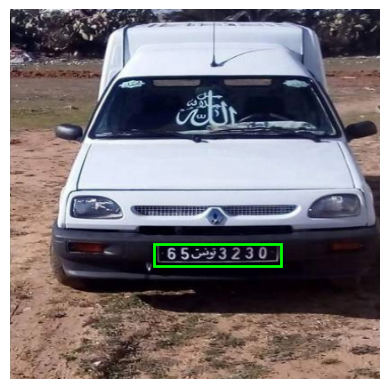

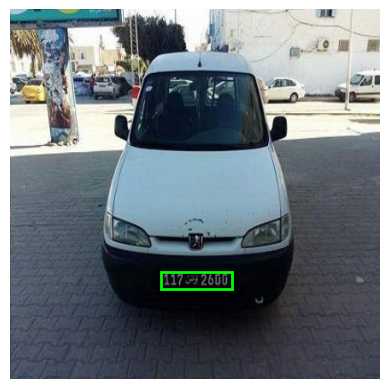

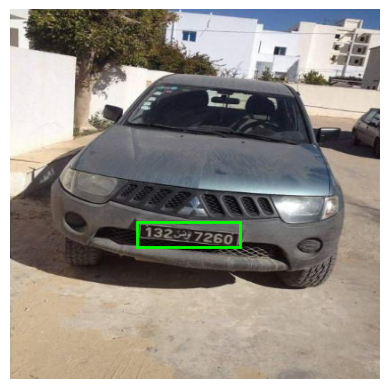

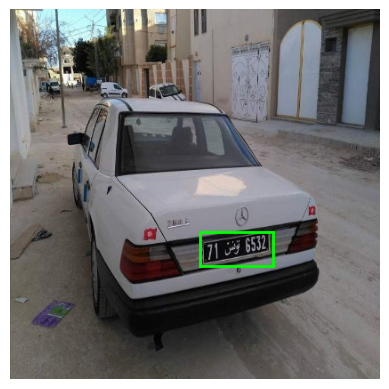

In [11]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Helper to plot image + bbox
def plot_sample(img_tensor, bbox_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()  # CHW → HWC
    h, w = img.shape[:2]
    x_c, y_c, bw, bh = bbox_tensor.numpy()

    # Convert center format to (x1, y1)
    x1 = int((x_c - bw / 2) * w)
    y1 = int((y_c - bh / 2) * h)
    bw = int(bw * w)
    bh = int(bh * h)

    fig, ax = plt.subplots(1)
    ax.imshow(img)
    rect = patches.Rectangle((x1, y1), bw, bh, linewidth=2, edgecolor='lime', facecolor='none')
    ax.add_patch(rect)
    plt.axis('off')
    plt.show()

# Show 4 samples
images, boxes = next(iter(dataloader))
for i in range(4):
    plot_sample(images[i], boxes[i])


YOLOv8 Setup + Dataset Preparation

# YOLOv8 Setup + Dataset Preparation

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
import pandas as pd
import cv2
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
base_path = '/content/dataset'
img_source = '/content/drive/MyDrive/Colab Notebooks/NUMBER-PLATE/Licplatesdetection_train/license_plates_detection_train'
csv_path = '/content/drive/MyDrive/Colab Notebooks/NUMBER-PLATE/Licplatesdetection_train.csv'
df = pd.read_csv(csv_path)

# Create folders
for split in ['train', 'val']:
    os.makedirs(f"{base_path}/images/{split}", exist_ok=True)
    os.makedirs(f"{base_path}/labels/{split}", exist_ok=True)

# Train/Val Split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Function to save YOLO label
def save_yolo_label(row, split):
    img_id = row['img_id']
    img_path = os.path.join(img_source, img_id)
    shutil.copy(img_path, f"{base_path}/images/{split}/{img_id}")

    # Convert bbox to YOLO format
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    x_center = ((row['xmin'] + row['xmax']) / 2) / w
    y_center = ((row['ymin'] + row['ymax']) / 2) / h
    width = (row['xmax'] - row['xmin']) / w
    height = (row['ymax'] - row['ymin']) / h

    label_path = f"{base_path}/labels/{split}/{img_id.replace('.jpg', '.txt')}"
    with open(label_path, 'w') as f:
        f.write(f"0 {x_center} {y_center} {width} {height}\n")

# Save all labels and images
for _, row in train_df.iterrows():
    save_yolo_label(row, 'train')

for _, row in val_df.iterrows():
    save_yolo_label(row, 'val')


# YOLOv8 Config + Start Training

In [3]:
yaml_content = """
path: /content/dataset
train: images/train
val: images/val

nc: 1
names: ['license_plate']
"""

with open("/content/dataset.yaml", "w") as f:
    f.write(yaml_content.strip())


In [4]:
from ultralytics import YOLO

# Load YOLOv8n (nano model)
model = YOLO("yolov8n.pt")

# Train
model.train(
    data="/content/dataset.yaml",
    epochs=20,
    imgsz=416,
    batch=8,
    name="plate-detector"
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 76.8MB/s]


Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=plate-detector, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12

100%|██████████| 755k/755k [00:00<00:00, 13.9MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 65.9MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2073.8±1322.6 MB/s, size: 116.0 KB)


train: Scanning /content/dataset/labels/train... 720 images, 0 backgrounds, 0 corrupt: 100%|██████████| 720/720 [00:00<00:00, 1488.64it/s]

train: New cache created: /content/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 420.1±79.1 MB/s, size: 114.9 KB)


val: Scanning /content/dataset/labels/val... 180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<00:00, 1188.47it/s]

val: New cache created: /content/dataset/labels/val.cache


Plotting labels to runs/detect/plate-detector/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs/detect/plate-detector
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      0.52G      1.378      2.001      1.113         12        416: 100%|██████████| 90/90 [00:08<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.55it/s]

                   all        180        180          1      0.296      0.974      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20     0.598G      1.287      1.179      1.084         15        416: 100%|██████████| 90/90 [00:06<00:00, 14.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.27it/s]

                   all        180        180      0.861      0.897      0.939      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20     0.615G      1.316      1.117      1.103         14        416: 100%|██████████| 90/90 [00:06<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.18it/s]

                   all        180        180      0.941      0.933      0.972      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20     0.633G      1.275     0.9854      1.047         15        416: 100%|██████████| 90/90 [00:06<00:00, 14.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.13it/s]

                   all        180        180      0.951      0.922      0.985      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      0.65G       1.21      0.884      1.059         13        416: 100%|██████████| 90/90 [00:06<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.11it/s]

                   all        180        180      0.978      0.983      0.994      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20     0.666G      1.185     0.8532      1.038         16        416: 100%|██████████| 90/90 [00:06<00:00, 14.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.66it/s]

                   all        180        180      0.936      0.981      0.971       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20     0.684G      1.178     0.7871      1.041         17        416: 100%|██████████| 90/90 [00:06<00:00, 14.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.79it/s]

                   all        180        180       0.98      0.989      0.995      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20     0.701G      1.139     0.7321      1.032         11        416: 100%|██████████| 90/90 [00:06<00:00, 14.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.25it/s]

                   all        180        180      0.973      0.984      0.994      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20     0.717G      1.083     0.6718      1.001         13        416: 100%|██████████| 90/90 [00:05<00:00, 15.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.01it/s]

                   all        180        180      0.983      0.983      0.993      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20     0.734G      1.058     0.6357     0.9967         11        416: 100%|██████████| 90/90 [00:06<00:00, 14.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.32it/s]

                   all        180        180      0.998          1      0.995       0.74


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      0.75G      1.006     0.6529      1.006          8        416: 100%|██████████| 90/90 [00:06<00:00, 14.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.86it/s]

                   all        180        180      0.991      0.989      0.994       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20     0.768G      1.009     0.6206      1.007          8        416: 100%|██████████| 90/90 [00:06<00:00, 14.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.26it/s]

                   all        180        180      0.981      0.961      0.993      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20     0.783G     0.9878     0.6111      1.003          8        416: 100%|██████████| 90/90 [00:06<00:00, 14.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.55it/s]

                   all        180        180      0.994      0.994      0.995      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20     0.801G     0.9929     0.5918     0.9963          8        416: 100%|██████████| 90/90 [00:06<00:00, 14.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.30it/s]

                   all        180        180          1       0.99      0.995      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20     0.818G     0.9657     0.5665     0.9941          8        416: 100%|██████████| 90/90 [00:06<00:00, 14.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.60it/s]

                   all        180        180      0.999          1      0.995      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20     0.836G     0.9104     0.5284     0.9607          8        416: 100%|██████████| 90/90 [00:06<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.91it/s]

                   all        180        180      0.992          1      0.995      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20     0.852G     0.9199     0.5221     0.9646          8        416: 100%|██████████| 90/90 [00:06<00:00, 15.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.97it/s]

                   all        180        180      0.994      0.994      0.995      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20     0.869G      0.894     0.5046     0.9581          8        416: 100%|██████████| 90/90 [00:06<00:00, 14.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.35it/s]

                   all        180        180      0.989          1      0.995      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20     0.887G     0.8614     0.4847     0.9352          8        416: 100%|██████████| 90/90 [00:06<00:00, 14.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.49it/s]

                   all        180        180      0.993          1      0.995      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20     0.904G     0.8579     0.4829     0.9471          8        416: 100%|██████████| 90/90 [00:06<00:00, 14.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.01it/s]

                   all        180        180      0.993          1      0.995      0.785



20 epochs completed in 0.041 hours.
Optimizer stripped from runs/detect/plate-detector/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/plate-detector/weights/best.pt, 6.2MB

Validating runs/detect/plate-detector/weights/best.pt...
Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00, 11.73it/s]


                   all        180        180      0.993          1      0.995      0.787
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/plate-detector


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b7688772c50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

Run YOLOv8 on Test Images + Visualize Predictions

In [5]:
# Load your custom trained model
model = YOLO('/content/runs/detect/plate-detector/weights/best.pt')


visualization

In [ ]:
import glob
import matplotlib.pyplot as plt
import cv2


image 1/1 /content/drive/MyDrive/Colab Notebooks/NUMBER-PLATE/test/test/test/1012.jpg: 320x416 1 license_plate, 47.3ms
Speed: 1.7ms preprocess, 47.3ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 416)


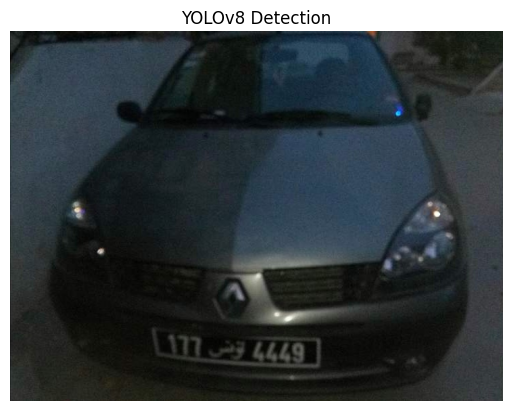

In [6]:
# Path to test images
test_img_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/NUMBER-PLATE/test/test/test/*.jpg')

# Run inference on one image
results = model(test_img_paths[0])  # or loop over all

# Plot prediction
results[0].plot()
plt.imshow(cv2.cvtColor(results[0].orig_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("YOLOv8 Detection")
plt.show()



image 1/1 /content/drive/MyDrive/Colab Notebooks/NUMBER-PLATE/test/test/test/1012.jpg: 320x416 1 license_plate, 8.3ms
Speed: 1.5ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 416)


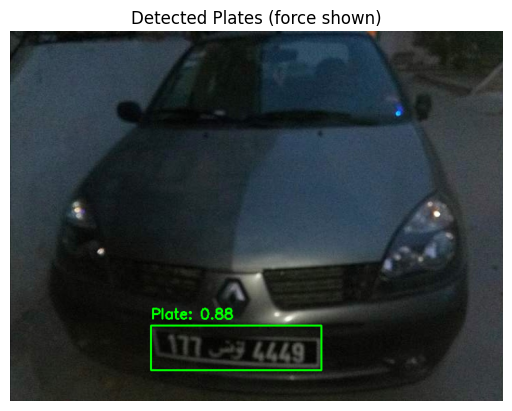

In [7]:
import torch

# Get result from the first image
results = model(test_img_paths[0])

# Manually extract prediction
boxes = results[0].boxes
img = results[0].orig_img.copy()

if boxes is not None and boxes.shape[0] > 0:
    for box in boxes:
        coords = box.xyxy[0].cpu().numpy().astype(int)
        conf = box.conf.item()
        cls = int(box.cls.item())

        # Draw bounding box
        x1, y1, x2, y2 = coords
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"Plate: {conf:.2f}"
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

else:
    print("No plates detected")

# Show image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Detected Plates (force shown)")
plt.show()


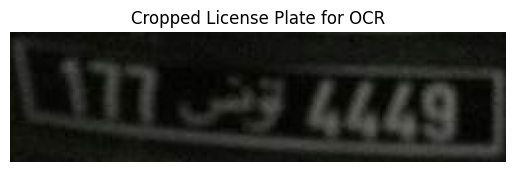

In [8]:
boxes = results[0].boxes
orig_img = results[0].orig_img

if boxes is not None and boxes.shape[0] > 0:
    # Take first detected box
    x1, y1, x2, y2 = boxes.xyxy[0].cpu().numpy().astype(int)

    # Crop the plate region
    cropped_plate = orig_img[y1:y2, x1:x2]

    # Show cropped plate
    plt.imshow(cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2RGB))
    plt.title("Cropped License Plate for OCR")
    plt.axis('off')
    plt.show()

else:
    print("No plate detected to crop.")


In [9]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 25.8 MB/s eta 0:00:00


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteDetected: 77 (Confidence: 0.20)


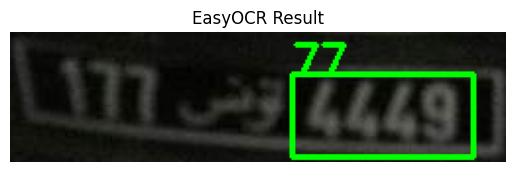

In [10]:
import easyocr

# Create EasyOCR reader (Arabic + English)
reader = easyocr.Reader(['en', 'ar'], gpu=True)

# Run OCR
ocr_result = reader.readtext(cropped_plate)

# Print results
for (bbox, text, conf) in ocr_result:
    print(f"Detected: {text} (Confidence: {conf:.2f})")

#Draw the text on image
img_copy = cropped_plate.copy()
for (bbox, text, conf) in ocr_result:
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = tuple(map(int, top_left))
    bottom_right = tuple(map(int, bottom_right))
    cv2.rectangle(img_copy, top_left, bottom_right, (0,255,0), 2)
    cv2.putText(img_copy, text, top_left, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
plt.title("EasyOCR Result")
plt.axis('off')
plt.show()


# 3.Prepare CRNN Dataset + Label Encoding

Build CRNN Character Set & Label Encoder

In [11]:
import string

# Define character set
characters = string.digits + string.ascii_uppercase

# Mapping
char_to_idx = {char: i + 1 for i, char in enumerate(characters)}
idx_to_char = {i + 1: char for i, char in enumerate(characters)}
num_classes = len(characters) + 1


Create PyTorch Dataset for Recognition

In [12]:
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as T
import cv2
import os
from PIL import Image
class LicensePlateOCRDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform or T.Compose([
            T.Resize((32, 128)),
            T.ToTensor(),
            T.Normalize((0.5,), (0.5,))
        ])

    def encode_text(self, text):
        return [char_to_idx[char] for char in text if char in char_to_idx]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      row = self.data.iloc[idx]
      img_path = os.path.join(self.img_dir, row['img_id'])

      # Load image
      image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
      image = cv2.resize(image, (128, 32))
      image = Image.fromarray(image)
      image = self.transform(image)

      # Encode label
      label = self.encode_text(row['text'])
      label = torch.tensor(label, dtype=torch.long)

      return image, label



test dataset

In [13]:
ocr_dataset = LicensePlateOCRDataset(
    csv_file='/content/drive/MyDrive/Colab Notebooks/NUMBER-PLATE/Licplatesrecognition_train.csv',
    img_dir='/content/drive/MyDrive/Colab Notebooks/NUMBER-PLATE/Licplatesrecognition_train/license_plates_recognition_train'
)

img, label = ocr_dataset[0]
print("Image shape:", img.shape)
print("Encoded label:", label)


Image shape: torch.Size([1, 32, 128])
Encoded label: tensor([ 2,  2,  8, 30,  4, 10,  9, 10])


# **CRNN Model Architecture**

In [14]:
import torch.nn as nn

class CRNN(nn.Module):
    def __init__(self, imgH, nc, nclass):
        super(CRNN, self).__init__()

        # Feature extractor (CNN)
        self.cnn = nn.Sequential(
            nn.Conv2d(nc, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(), nn.MaxPool2d((2,1)),
            nn.Conv2d(256, 512, 3, 1, 1), nn.ReLU(), nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(), nn.BatchNorm2d(512), nn.MaxPool2d((2,1)),
            nn.Conv2d(512, 512, 2, 1, 0), nn.ReLU()
        )

        self.rnn1 = nn.LSTM(512, 256, bidirectional=True, batch_first=True)
        self.rnn2 = nn.LSTM(512, 256, bidirectional=True, batch_first=True)

        # Output layer
        self.linear = nn.Linear(512, nclass)

    def forward(self, x):
      conv = self.cnn(x)  # [B, C, H, W]
      b, c, h, w = conv.size()
      assert h == 1, "height must be 1 after conv"
      conv = conv.squeeze(2)         # [B, C, W]
      conv = conv.permute(0, 2, 1)   # [B, W, C]

      rnn_out, _ = self.rnn1(conv)   #  first LSTM
      rnn_out, _ = self.rnn2(rnn_out)  #  second LSTM
      out = self.linear(rnn_out)     # [B, W, num_classes]

      return out.permute(1, 0, 2)    # CTC wants [T, B, num_classes]



In [15]:
crnn = CRNN(imgH=32, nc=1, nclass=num_classes)
print("Model created. Total parameters:", sum(p.numel() for p in crnn.parameters()))


Model created. Total parameters: 8723749


# **Training with ctc loss**

In [16]:
def collate_fn(batch):
    images, labels = zip(*batch)

    # Pad labels and store lengths
    label_lengths = torch.tensor([len(l) for l in labels], dtype=torch.long)
    labels = torch.cat(labels)

    images = torch.stack(images)
    return images, labels, label_lengths


In [17]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    ocr_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn
)


In [18]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
crnn = crnn.to(device)

criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(crnn.parameters(), lr=0.001)


**NOTE:** while doing for the first time it was showing high loss so when you run this make sure you adjust and bring the loss to single digit for better results.

In [20]:
for epoch in range(35):
    crnn.train()
    total_loss = 0

    for images, labels, label_lengths in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = crnn(images)  # [T, B, num_classes]
        input_lengths = torch.full(size=(preds.size(1),), fill_value=preds.size(0), dtype=torch.long)

        loss = criterion(preds, labels, input_lengths, label_lengths)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}")


Epoch 1 Loss: 10.8418
Epoch 2 Loss: 8.2755
Epoch 3 Loss: 7.3022
Epoch 4 Loss: 8.8277
Epoch 5 Loss: 4.7276
Epoch 6 Loss: 3.6786
Epoch 7 Loss: 3.6481
Epoch 8 Loss: 5.2851
Epoch 9 Loss: 3.0054
Epoch 10 Loss: 2.3804
Epoch 11 Loss: 1.8776
Epoch 12 Loss: 1.5155
Epoch 13 Loss: 1.1685
Epoch 14 Loss: 1.1232
Epoch 15 Loss: 1.1055
Epoch 16 Loss: 1.1752
Epoch 17 Loss: 3.7884
Epoch 18 Loss: 5.4865
Epoch 19 Loss: 2.8615
Epoch 20 Loss: 3.5965
Epoch 21 Loss: 1.3609
Epoch 22 Loss: 2.1043
Epoch 23 Loss: 1.2738
Epoch 24 Loss: 0.9281
Epoch 25 Loss: 0.6554
Epoch 26 Loss: 0.8497
Epoch 27 Loss: 0.8748
Epoch 28 Loss: 0.6999
Epoch 29 Loss: 0.8933
Epoch 30 Loss: 1.0136
Epoch 31 Loss: 1.1091
Epoch 32 Loss: 1.1708
Epoch 33 Loss: 0.8339
Epoch 34 Loss: 1.0626
Epoch 35 Loss: 1.0456


# **Inference + Decode Predicted**

In [21]:
def ctc_decode(preds):
    preds_idx = preds.permute(1, 0, 2).argmax(2)  # [B, T]
    decoded = []

    for pred in preds_idx:
        chars = []
        prev = -1
        for p in pred:
            p = p.item()
            if p != prev and p != 0:
                chars.append(idx_to_char[p])
            prev = p
        print("Intermediate decoded:", chars)
        decoded.append(''.join(chars))

    return decoded


In [22]:
# Load one image
img, _ = ocr_dataset[0]
img = img.unsqueeze(0).to(device)

# Run prediction
crnn.eval()
with torch.no_grad():
    preds = crnn(img)  # [T, B, C]

decoded_text = ctc_decode(preds)
print("Predicted Plate Text:", decoded_text[0])


Intermediate decoded: ['1', '1', '7', 'T', '3', '9', '8', '9']
Predicted Plate Text: 117T3989


**Testing on one image**

In [23]:
from ultralytics import YOLO
import cv2
import torch

# Load one test image
test_image_path = '/content/drive/MyDrive/Colab Notebooks/NUMBER-PLATE/test/test/test/1012.jpg'
img = cv2.imread(test_image_path)

# Detect license plate
results = model(img)
boxes = results[0].boxes.xyxy.cpu().numpy()



0: 320x416 1 license_plate, 9.0ms
Speed: 1.7ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 416)


# ***Crop the Plate Region***

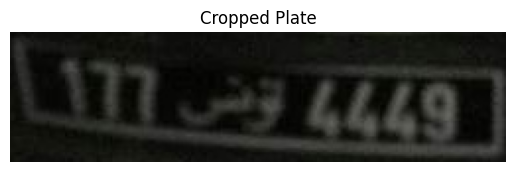

In [24]:
# Take the first detected box (assuming 1 plate per image)
if len(boxes) > 0:
    x1, y1, x2, y2 = boxes[0].astype(int)
    cropped_plate = img[y1:y2, x1:x2]

    # Show the cropped plate (optional)
    from matplotlib import pyplot as plt
    plt.imshow(cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Plate")
    plt.axis('off')
    plt.show()
else:
    print("No license plate detected.")


# **Preprocess for CRNN and Predict**

In [25]:
from PIL import Image
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((32, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Convert to grayscale + PIL
gray = cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2GRAY)
pil_img = Image.fromarray(gray)
input_tensor = transform(pil_img).unsqueeze(0).to(device)

# Predict
crnn.eval()
with torch.no_grad():
    preds = crnn(input_tensor)

decoded = ctc_decode(preds)
print("Predicted Plate Number:", decoded[0])


Intermediate decoded: ['1', '7', '7', 'T', '4', '4', '4', '9']
Predicted Plate Number: 177T4449


# **perfect we got the result , running for all the test images and saving in csv format**

In [26]:
import os

test_dir = '/content/drive/MyDrive/Colab Notebooks/NUMBER-PLATE/test/test/test'
submission = []

# Loop through each image
for img_name in sorted(os.listdir(test_dir)):
    img_path = os.path.join(test_dir, img_name)
    img = cv2.imread(img_path)

    # Detect license plate
    results = model(img)
    boxes = results[0].boxes.xyxy.cpu().numpy()

    if len(boxes) > 0:
        x1, y1, x2, y2 = boxes[0].astype(int)
        cropped = img[y1:y2, x1:x2]

        # Preprocess for CRNN
        gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        pil_img = Image.fromarray(gray)
        input_tensor = transform(pil_img).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            preds = crnn(input_tensor)
        decoded = ctc_decode(preds)
        plate_text = decoded[0]
    else:
        plate_text = ""

    submission.append({'img_id': img_name, 'text': plate_text})



0: 288x416 1 license_plate, 46.6ms
Speed: 1.5ms preprocess, 46.6ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 416)
Intermediate decoded: ['9', '4', 'T', '5', '7', '3']

0: 416x256 1 license_plate, 46.1ms
Speed: 1.4ms preprocess, 46.1ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 256)
Intermediate decoded: ['1', '7', '3', 'T', '9', '1', '6']

0: 416x320 1 license_plate, 50.4ms
Speed: 1.8ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 320)
Intermediate decoded: ['7', '1', 'T', '1', '5', '2', '4']

0: 256x416 1 license_plate, 54.5ms
Speed: 1.3ms preprocess, 54.5ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)
Intermediate decoded: ['9', '2', 'T', '3', '8', '3', '9']

0: 416x256 1 license_plate, 10.6ms
Speed: 1.2ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 256)
Intermediate decoded: ['7', '6', 'T', '2', '7', '1', '4']

0: 416x256 1 license_plate, 7.3ms
Speed: 1.2ms pr

In [27]:
import pandas as pd

df_sub = pd.DataFrame(submission)
df_sub.to_csv('final_submission.csv', index=False)
print("Submission saved as final_submission.csv")


Submission saved as final_submission.csv


# **find accuracy**

In [29]:
import pandas as pd

truth_df = pd.read_csv('/content/truth_final_submission.csv')
pred_df = pd.read_csv('/content/final_submission.csv')


In [30]:
merged_df = truth_df.merge(pred_df, on='img_id', suffixes=('_true', '_pred'))

In [31]:
from difflib import SequenceMatcher

def char_accuracy(a, b):
    return SequenceMatcher(None, a, b).ratio()

total = len(merged_df)
exact_match = 0
char_acc_total = 0

for _, row in merged_df.iterrows():
    true_text = str(row['text_true']).strip()
    pred_text = str(row['text_pred']).strip()

    if true_text == pred_text:
        exact_match += 1

    char_acc_total += char_accuracy(true_text, pred_text)

full_acc = exact_match / total * 100
char_level_acc = char_acc_total / total * 100

print(f"Full Match Accuracy: {full_acc:.2f}%")
print(f"Character-Level Accuracy: {char_level_acc:.2f}%")


Full Match Accuracy: 90.00%
Character-Level Accuracy: 98.07%


In [33]:
# model download
torch.save(crnn.state_dict(), 'crnn_final.pth')

# ***converting according to the final submission***

In [9]:
import pandas as pd
import re

def to_one_hot(digit):
    vec = [0] * 10
    if digit.isdigit():
        vec[int(digit)] = 1
    return vec

# Load
df = pd.read_csv("/content/final_submission (1).csv")

records = []
for _, row in df.iterrows():
    raw_name, plate = row['img_id'], row['text']
    img_num = re.findall(r'\d+', raw_name)[0]
    digits = ''.join(filter(str.isdigit, plate))

    for i in range(7):
        row_id = f"img_{img_num}_{i+1}"
        if i < len(digits):
            one_hot = to_one_hot(digits[i])
        else:
            one_hot = [0] * 10
        records.append([row_id] + one_hot)

# Create DataFrame
columns = ['id'] + [str(i) for i in range(10)]
final_df = pd.DataFrame(records, columns=columns)

# Sort correctly based on img number and sub index
def extract_sort_keys(row_id):
    match = re.match(r"img_(\d+)_(\d+)", row_id)
    return (int(match.group(1)), int(match.group(2))) if match else (999999, 9)

final_df = final_df.sort_values(by='id', key=lambda col: col.map(extract_sort_keys))

# Save
final_df.to_csv("/content/final_submission_onehot.csv", index=False)
print("Sorted & saved with proper row IDs:", final_df.shape)


Sorted & saved with proper row IDs: (1470, 11)


In [10]:
pd = pd.read_csv("/content/final_submission_onehot.csv")
pd.head(20)

,id,0,1,2,3,4,5,6,7,8,9
0,img_901_1,0,1,0,0,0,0,0,0,0,0
1,img_901_2,0,0,0,0,0,0,1,0,0,0
2,img_901_3,0,0,0,0,0,0,0,0,0,1
3,img_901_4,0,0,0,0,0,0,0,0,0,1
4,img_901_5,0,0,0,0,0,0,1,0,0,0
5,img_901_6,0,0,0,0,0,0,0,0,1,0
6,img_901_7,0,0,0,0,0,1,0,0,0,0
7,img_902_1,0,1,0,0,0,0,0,0,0,0
8,img_902_2,0,0,1,0,0,0,0,0,0,0
9,img_902_3,1,0,0,0,0,0,0,0,0,0
